In [1]:
script = False
cluster = False

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
import timm

import seaborn as sn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps
#from transformers import ViTFeatureExtractor, ViTForImageClassification

from memory_profiler import memory_usage
import random
import os
import gc
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt

if(script):
    from tqdm import tqdm
else: 
    from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        #print(labels)
        #tensor_tmp = torch.tensor(labels.values, dtype=torch.float32)
        #self.labels = tensor_tmp
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        """
        #Plotting with Astropy and saving as png (not used right now)
        print('Astropy')
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.savefig('Image.png', bbox_inches='tight')
        plt.close()
        new_image = Image.open('Image.png')
        return(new_image)
        """
        #new_image = np.empty((3, 46, 46)) #I NEED TO CHANGE MY IMAGE SIZES!!!!!!
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        #label = self.labels.iloc[idx].to_dict()
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        #print(sample)
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()


In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
seed_everything(9)

if(cluster):
    path = '/data/des90.a/data/sgonzal/training_data/' #DES cluster
    path = '/Data/' #CHTC
else:
    path = '/Users/jimenagonzalez/research/DSPL/Modeling_strong_lenses/simulations/Data/fit_files/' #local
    
#200
npos = 200
num_workers = 0
num_epochs = 10

hdu_list = fits.open(path + 'simu.fits')
idx = random.sample(range(len(hdu_list[1].data)), npos)
images_dataset  = hdu_list[1].data[idx,:].astype(np.float32)
data_dataset = pd.DataFrame(hdu_list[2].data[:][idx])
data_dataset = data_dataset.drop('TILENAME', axis=1)
labels_dataset = data_dataset.drop(['Y6_COADD_OBJECT_ID', 'HPIX_16384', 'HPIX_4096', 'DNF_ZMEAN_SOF', 'RA', 'DEC', 
        'FLUX_RADIUS_G', 'FLUX_RADIUS_R', 'FLUX_RADIUS_I', 'FLUX_RADIUS_Z', 'KRON_RADIUS', 'GAP_FLUX_G', 
        'MOF_BDF_FLUX_G', 'MOF_PSF_FLUX_G', 'SOF_BDF_FLUX_G', 'SOF_PSF_FLUX_G', 'MAG_AUTO_G', 'MAG_APER_4_G', 
        'MAG_APER_8_G', 'SOF_BDF_G_1', 'Y3_COADD_OBJECT_ID', 'REFMAG', 'REFMAG_ERR', 'LUM', 'ZREDMAGIC', 
        'ZREDMAGIC_E', 'CHISQ', 'Z_LENS', 'MAG_G', 'MAG_R', 'MAG_I', 'MAG_Z', 'MAG_ERR_G', 'MAG_ERR_R', 'MAG_ERR_I', 
        'MAG_ERR_Z', 'ZG', 'ZR', 'ZI', 'ZZ', 'SOF_BDF_G_2', 'IMAFLAGS_ISO_G', 'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I', 
        'IMAFLAGS_ISO_Z', 'EXT_COADD', 'FWHM_WMEAN_G', 'FWHM_WMEAN_R', 'FWHM_WMEAN_I', 'FWHM_WMEAN_Z', 
        'SKYBRITE_WMEAN_G', 'SKYBRITE_WMEAN_R', 'SKYBRITE_WMEAN_I', 'SKYBRITE_WMEAN_Z', 'Z1', 'LENSED_MAG', 
        'mag_1', 'ISOLATION', 'MAGNIFICATION', 'POSITION1'], axis = 1)
labels_dataset = torch.tensor(labels_dataset.values, dtype=torch.float32)
hdu_list.close()

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

print(images_dataset.shape)

(200, 3, 45, 45)


In [6]:
train_dataset, other_dataset = make_train_test_datasets(images_dataset, data_dataset, labels_dataset, test_size=0.2, transform=transform)
valid_dataset, test_dataset = make_train_test_datasets(other_dataset.images, other_dataset.data, other_dataset.labels, test_size=0.5, transform=transform)
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 160, len test dataset: 20


In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, num_workers=num_workers, shuffle=True)
torch.save(test_loader, 'test_loader.pth')

In [8]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        if(not cluster):
            self.model = EfficientNet.from_pretrained('efficientnet-b0',  num_classes=n_classes)
            torch.save(self.model.state_dict(), 'initial_model.pt')
        else:
            self.model = EfficientNet.from_name('efficientnet-b0',  num_classes=n_classes)
            self.model.load_state_dict(torch.load('initial_model.pt'))

    def forward(self, x):

        x = self.model(x)

        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        #for i, (data, target, sample_img, sample_data) in tqdm(enumerate(train_loader)):
        for i, sample in enumerate(tqdm(train_loader)):

            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output = torch.squeeze(output)
            
            #target = target.float()
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Calculate Accuracy
            #accuracy = (output.argmax(dim=1) == target).float().mean()
            #accuracy = sum(output.argmax(dim=1) == target)
            accuracy = loss # I NEED TO UPDATE THIS AKDMFMAKDFMAKFGOIAJEROFMAOIMGOIAJMROGKMAOFMGAOFDLGMAKLFMGK
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader.dataset)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)):
            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                #accuracy = (output.argmax(dim=1) == target).float().mean()
                #accuracy = sum(output.argmax(dim=1) == target)
                accuracy = loss # TO UPDATE ADMFKAMDKFMAKDMFKAJDKGJNAOIERJGOIMRGOIJROITJIOJRGIOSJIFGJMSOIRGJISRJI
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader.dataset)

In [9]:
model = ViTBase16(n_classes=15, pretrained=True)

criterion = torch.nn.MSELoss() #nn.CrossEntropyLoss() #nn.CrossEntropyLoss() #nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0
cpu


In [10]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    
    best_val_loss = 100000000 # track of best accuracy
    model_data = pd.DataFrame()

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss.cpu().data.numpy())
        train_accs.append(train_acc.cpu().data.numpy())
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()
            
            #new_row = [train_loss, valid_loss, train_acc, valid_acc]
            #model_data = model_data.append(pd.Series(new_row, index=model_data.columns), ignore_index=True)

            if(valid_loss < best_val_loss):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, name_model)
                best_val_loss = valid_loss
                
    model_data['train_losses'] = train_losses#.cpu().data.numpy()#.detach().numpy()
    model_data['valid_losses'] = valid_losses
    model_data['train_accs'] = train_accs
    model_data['valid_accs'] = valid_accs
    model_data.to_csv('Complete_model.csv', index=False)

In [11]:
def plot_performance(cnn):
    loss_train = [x.item() for x in cnn.loss_train]
    loss_valid = [x.item() for x in cnn.loss_valid]
    train_acc = [x.item() for x in cnn.train_acc]
    valid_acc = [x.item() for x in cnn.validation_acc]
    
    x = np.linspace(1,len(cnn.loss_train),len(cnn.loss_train))
    fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
    
    ax1.set_title('Losses')
    ax1.set_xlabel('Epoch')
    ax1.scatter(x, loss_train, color = 'skyblue', alpha = 0.8, label = 'Training loss')
    ax1.scatter(x, loss_valid, color = 'limegreen', alpha = 0.8,  label = 'Validation loss')
    ax1.legend()
    
    ax2.set_title('Performance. Max: {:.4f}%'.format(100*cnn.validation_acc[-1].item()))
    ax2.set_xlabel('Epoch')
    ax2.scatter(x, train_acc, color = 'skyblue', alpha = 0.8,  label = 'Training Accuracy')
    ax2.scatter(x, valid_acc, color = 'limegreen', alpha = 0.8,  label = 'Validation Accuracy')
    ax2.legend()
    
    if(script):
        plt.savefig('Performance.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show(block=True)

In [12]:
name_model = 'model.pt'
#                          model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
mem_usage = memory_usage(( fit_tpu, (model, name_model, num_epochs, device, criterion, optimizer, train_loader, valid_loader)))


EPOCH 1 - TRAINING...


  0%|          | 0/8 [00:00<?, ?it/s]


	[TRAIN] EPOCH 1 - LOSS: 0.10153497755527496, ACCURACY: 0.10153497755527496

start valid_loader
EPOCH 1 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.10310836881399155, ACCURACY: 0.10310836881399155

EPOCH 2 - TRAINING...


  0%|          | 0/8 [00:00<?, ?it/s]


	[TRAIN] EPOCH 2 - LOSS: 0.0855209082365036, ACCURACY: 0.0855209082365036

start valid_loader
EPOCH 2 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.10186767578125, ACCURACY: 0.10186767578125

EPOCH 3 - TRAINING...


  0%|          | 0/8 [00:00<?, ?it/s]


	[TRAIN] EPOCH 3 - LOSS: 0.07022108137607574, ACCURACY: 0.07022108137607574

start valid_loader
EPOCH 3 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.10127123445272446, ACCURACY: 0.10127123445272446

EPOCH 4 - TRAINING...


  0%|          | 0/8 [00:00<?, ?it/s]


	[TRAIN] EPOCH 4 - LOSS: 0.05549014359712601, ACCURACY: 0.05549014359712601

start valid_loader
EPOCH 4 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.10181701183319092, ACCURACY: 0.10181701183319092

EPOCH 5 - TRAINING...


  0%|          | 0/8 [00:00<?, ?it/s]


	[TRAIN] EPOCH 5 - LOSS: 0.04241519421339035, ACCURACY: 0.04241519421339035

start valid_loader
EPOCH 5 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.10201146453619003, ACCURACY: 0.10201146453619003

EPOCH 6 - TRAINING...


  0%|          | 0/8 [00:00<?, ?it/s]


	[TRAIN] EPOCH 6 - LOSS: 0.030506853014230728, ACCURACY: 0.030506853014230728

start valid_loader
EPOCH 6 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.10401008278131485, ACCURACY: 0.10401008278131485

EPOCH 7 - TRAINING...


  0%|          | 0/8 [00:00<?, ?it/s]


	[TRAIN] EPOCH 7 - LOSS: 0.022642899304628372, ACCURACY: 0.022642899304628372

start valid_loader
EPOCH 7 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.1037798747420311, ACCURACY: 0.1037798747420311

EPOCH 8 - TRAINING...


  0%|          | 0/8 [00:00<?, ?it/s]


	[TRAIN] EPOCH 8 - LOSS: 0.01598307117819786, ACCURACY: 0.01598307117819786

start valid_loader
EPOCH 8 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.09786912053823471, ACCURACY: 0.09786912053823471

EPOCH 9 - TRAINING...


  0%|          | 0/8 [00:00<?, ?it/s]


	[TRAIN] EPOCH 9 - LOSS: 0.01205383986234665, ACCURACY: 0.01205383986234665

start valid_loader
EPOCH 9 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.0911681205034256, ACCURACY: 0.0911681205034256

EPOCH 10 - TRAINING...


  0%|          | 0/8 [00:00<?, ?it/s]


	[TRAIN] EPOCH 10 - LOSS: 0.009701033122837543, ACCURACY: 0.009701033122837543

start valid_loader
EPOCH 10 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.08735422044992447, ACCURACY: 0.08735422044992447



In [13]:
print('Maximum memory usage: %s' % max(mem_usage))

Maximum memory usage: 2250.79296875


In [14]:
name = 'model.pt'#'model.pt'#'other.pt' 
model = torch.load(name)
print('Maximum validation accuracy: {:.2f}%'.format(100*model.validation_acc[-1].item())) #Doesn't mean anything

Maximum validation accuracy: 8.74%


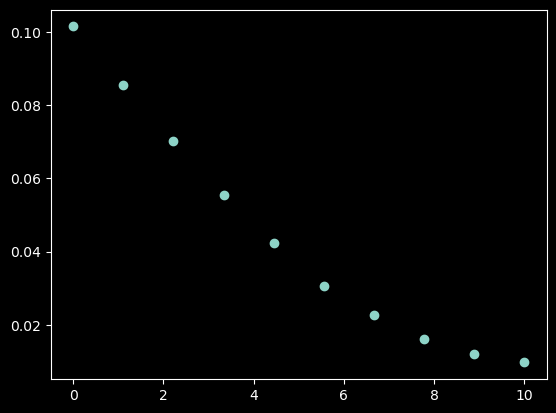

In [15]:
data_model = pd.read_csv('Complete_model.csv')
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
x = np.linspace(0, len(data_model), len(data_model))
plt.plot(x, data_model['train_losses'], 'o')
plt.plot(x, data_model['valid_losses'], 'o')
plt.show()

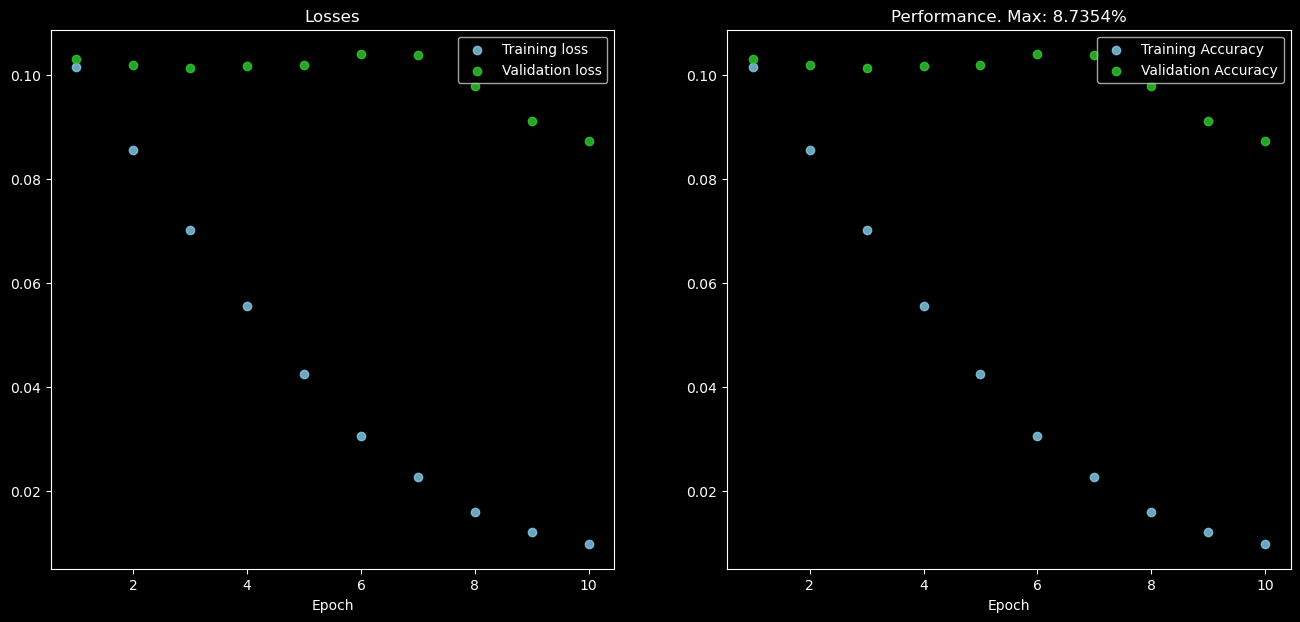

In [16]:
plot_performance(model)

In [17]:
def make_histo(name):
    plt.figure(figsize=(16,5)) 

    plt.subplot(1,2,1)
    plt.title('All distribution: ' + str(name))
    #data_all = np.concatenate((right_pos[name], wrong_pos[name]))
    plt.hist(data_dataset[name], edgecolor = 'black')
    
    if(script):
        plt.savefig('Histogram_' + str(name), bbox_inches='tight')
        plt.close()
    else:
        plt.show()

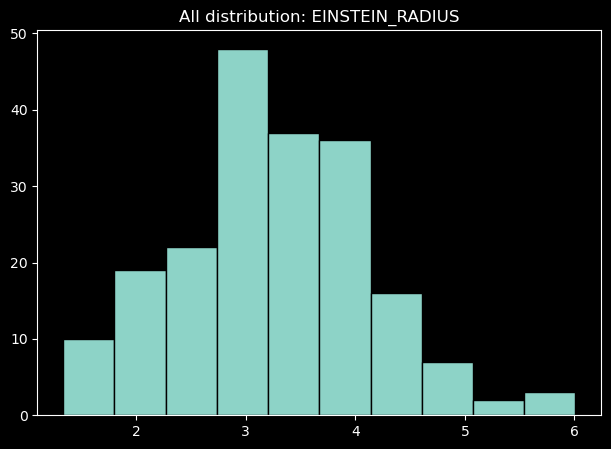

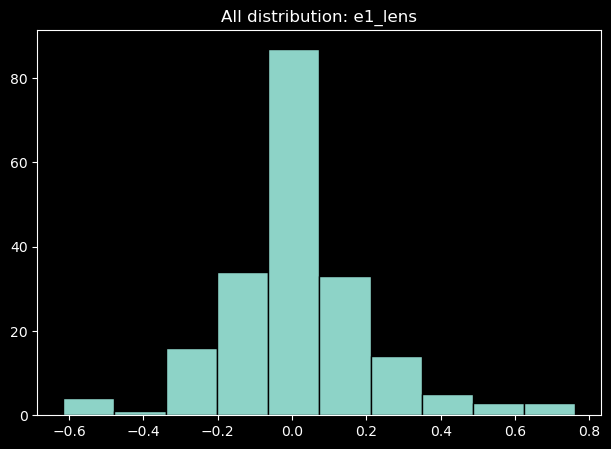

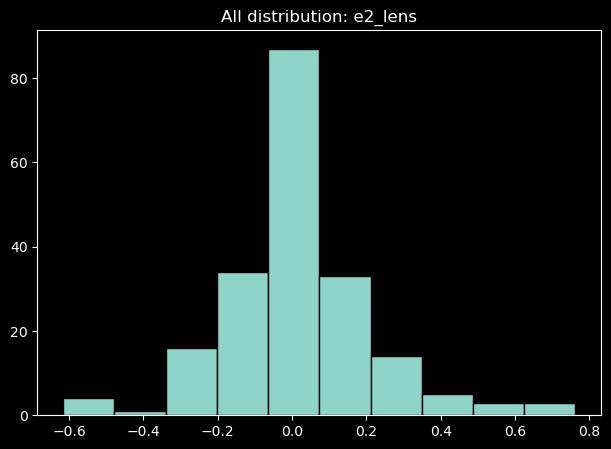

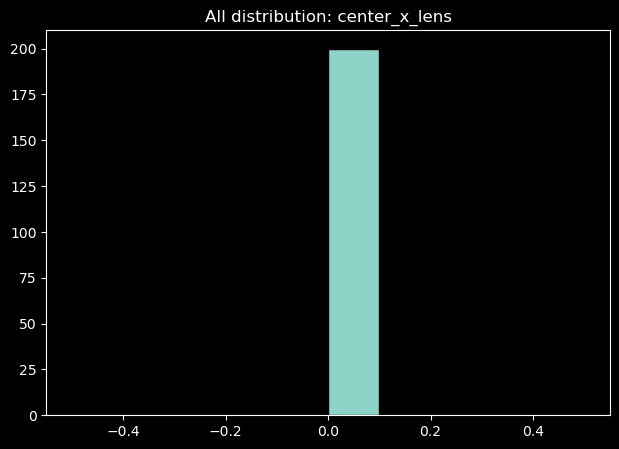

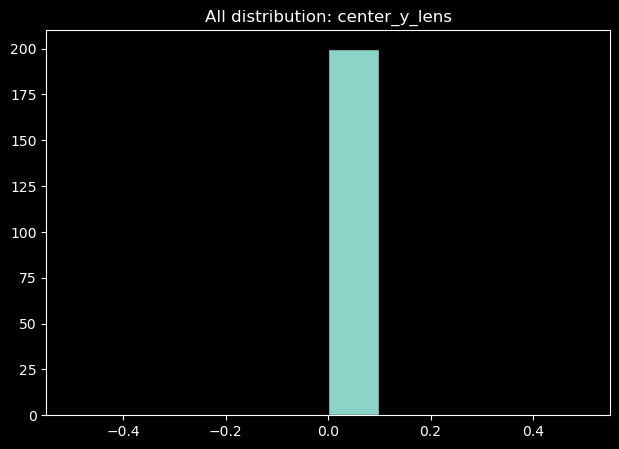

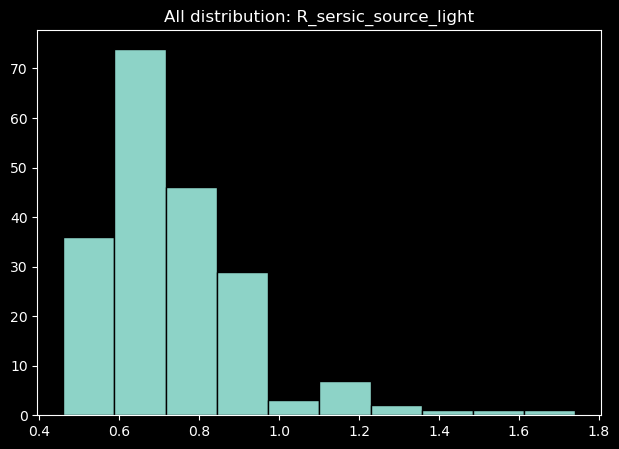

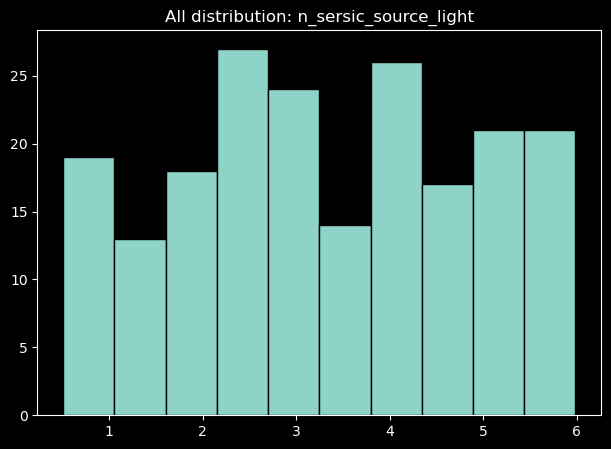

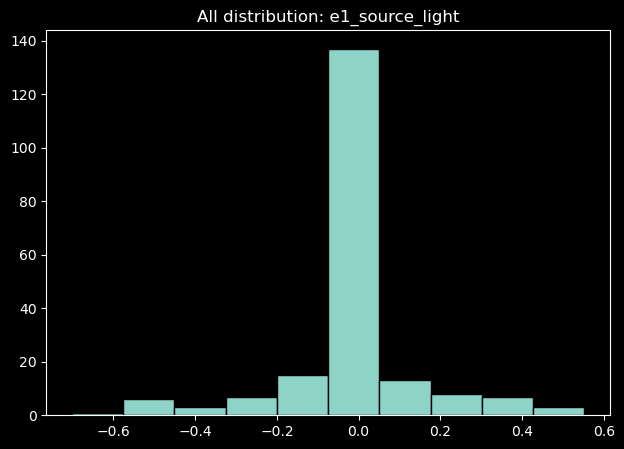

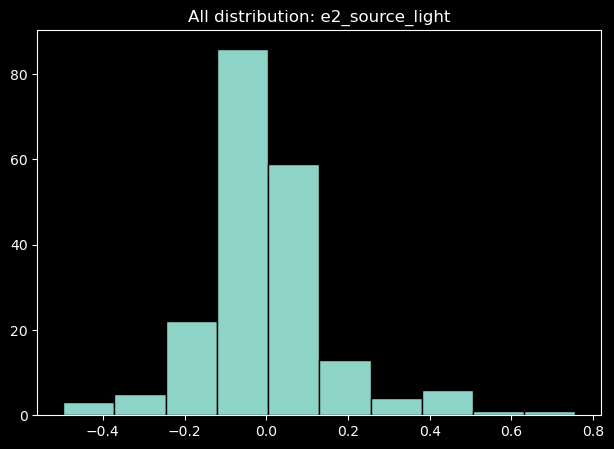

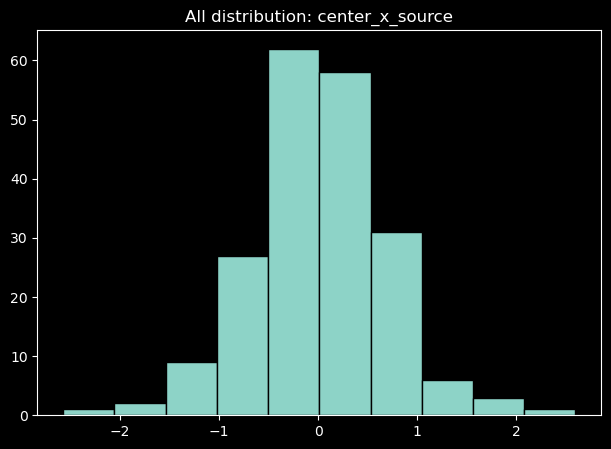

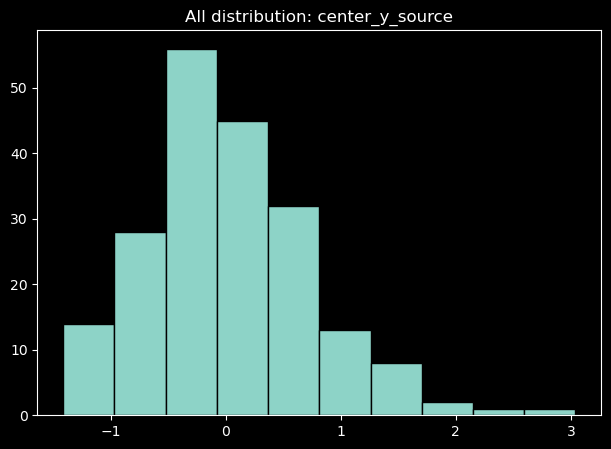

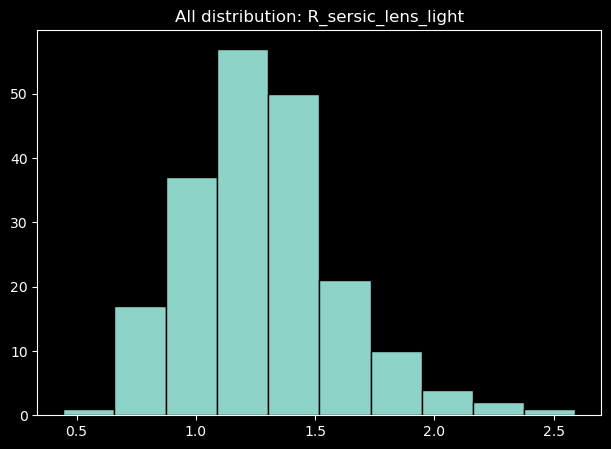

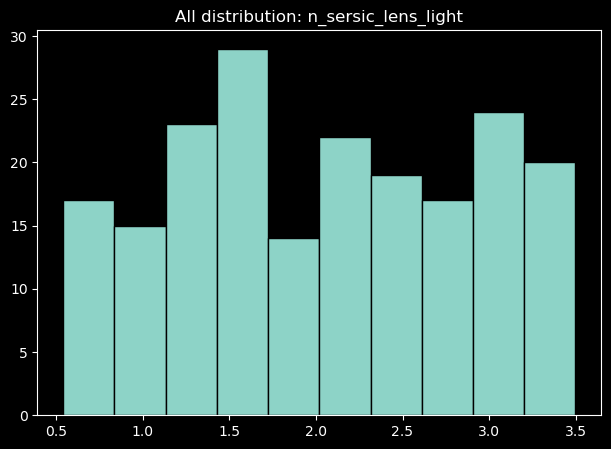

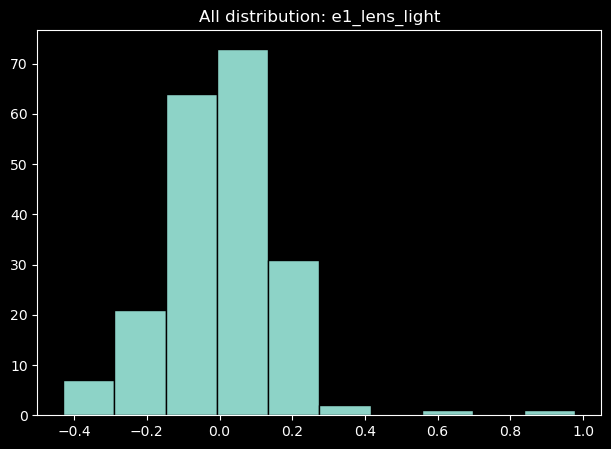

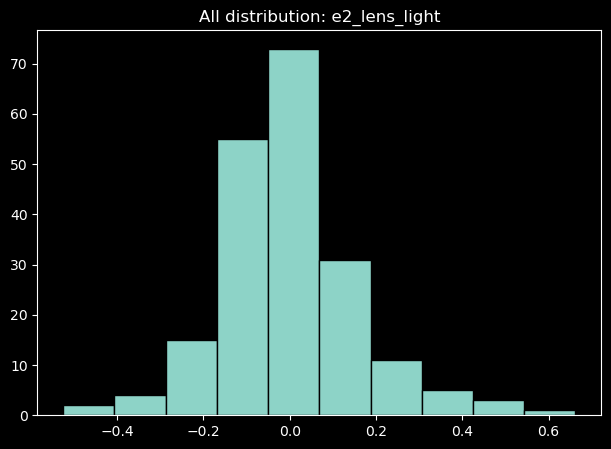

In [18]:
names = ['EINSTEIN_RADIUS', 'e1_lens',
       'e2_lens', 'center_x_lens', 'center_y_lens', 'R_sersic_source_light',
       'n_sersic_source_light', 'e1_source_light', 'e2_source_light',
       'center_x_source', 'center_y_source', 'R_sersic_lens_light',
       'n_sersic_lens_light', 'e1_lens_light', 'e2_lens_light']
for name in names:
    make_histo(name)